In [27]:
#!pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master --upgrade

In [2]:
# Libraries
# ==============================================================================
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
%config Completer.use_jedi = False

# Data

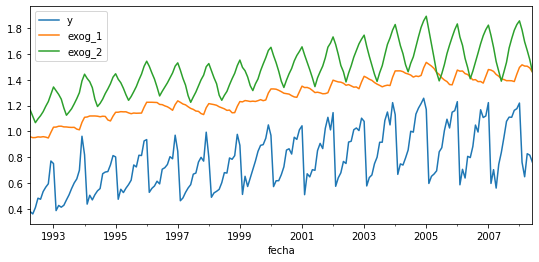

In [4]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',')

# data preprocessing
# ==============================================================================
data['fecha'] = pd.to_datetime(data['fecha'], format='%Y/%m/%d')
data = data.set_index('fecha')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

# ForecasterAutoregCustom without exogenous variables

In [7]:
# Custom function to create poredictors
# ==============================================================================
def create_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 10):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

In [8]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
              )
forecaster.fit(y=data_train.y)
forecaster

<class 'skforecast.ForecasterAutoregCustom.ForecasterAutoregCustom'> 
Regressor: LinearRegression() 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'> 
Training index frequancy: MS 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False} 

Test error (mse): 0.02469290541174575


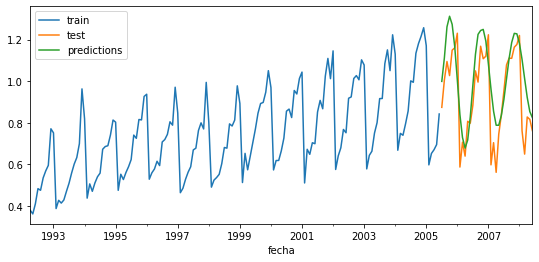

In [9]:
# Predict
# ==============================================================================
predictions = forecaster.predict(steps)

# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [11]:
# Grid search hiperparameters
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}


results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid search
# ==============================================================================
results_grid

root       INFO  Number of models compared: 4
loop lags_grid: 100%|█████████████████████████████| 1/1 [00:04<00:00,  4.06s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 100}



,lags,params,metric,max_depth,n_estimators
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.076737,10,100
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.077523,10,50
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.078077,5,100
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.078175,5,50


In [12]:
# Predictors importance
# ==============================================================================
print(forecaster.get_feature_importances())

[0.4696557  0.13166911 0.04552192 0.02614894 0.04243772 0.0302983
 0.05770474 0.01463964 0.02303568 0.10577152 0.05311673]


Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[0.06821433]


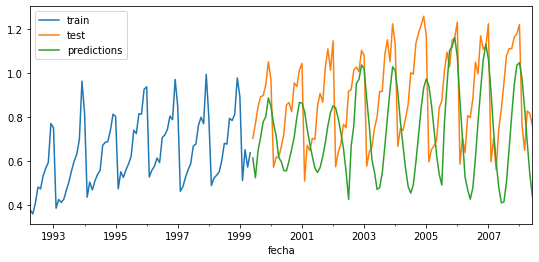

In [14]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)
print(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predictions')
ax.legend();

In [15]:
predicciones_backtest

1999-06-01    0.615551
1999-07-01    0.525748
1999-08-01    0.646688
1999-09-01    0.707766
1999-10-01    0.779449
                ...   
2008-02-01    0.973701
2008-03-01    0.839206
2008-04-01    0.686549
2008-05-01    0.542945
2008-06-01    0.439799
Freq: MS, Name: pred, Length: 109, dtype: float64

In [19]:
forecaster.fit(y=data_train.y)
predictions_1 = forecaster.predict(steps=steps)
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3])
np.allclose(predicciones_backtest, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoregCustom with 1 exogenous variables

In [21]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [23]:
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )
forecaster

<class 'skforecast.ForecasterAutoregCustom.ForecasterAutoregCustom'> 
Regressor: LinearRegression() 
Predictors created with function: create_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequancy: None 
Regressor parameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False} 

Test error (mse): 6.795365618889506e-30


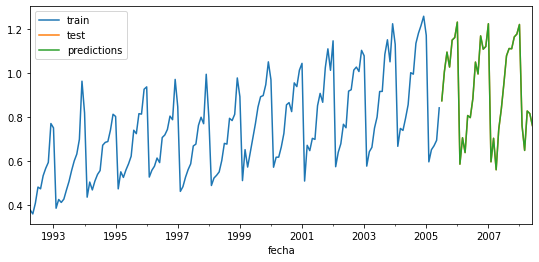

In [24]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

forecaster.fit(y=data_train.y, exog=data_train.exog_1)

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test.exog_1)

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error prediction
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [27]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train.y,
                        exog        = data_train.exog_1,
                        param_grid  = param_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
               )

# Results grid Search
# ==============================================================================
results_grid.head(4)

root       INFO  Number of models compared: 4
loop lags_grid: 100%|█████████████████████████████| 1/1 [00:04<00:00,  4.45s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 5, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.069862,5,50
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.071217,10,100
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.071439,10,50
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.071678,5,100


In [28]:
# Backtesting
# ==============================================================================
steps = 36
n_backtest = 36 * 3 + 1
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoregCustom(
                    regressor      = LinearRegression(),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

metrica, predicciones_backtest = backtesting_forecaster(
    forecaster = forecaster,
    y          = data.y,
    exog       = data.exog_1,
    initial_train_size = len(data_train),
    steps      = steps,
    metric     = 'mean_squared_error',
    verbose    = True
)

print(metrica)

Number of observations used for training or as initial window: 86
Number of observations used for backtesting: 109
    Number of folds: 4
    Number of steps per fold: 36
    Last fold only includes 1 observations
[9.15829515e-30]


In [29]:
# Verificar predicciones de backtesting
forecaster.fit(y=data_train.y, exog=data_train.exog_1)
predictions_1 = forecaster.predict(steps=steps, exog=data_test.exog_1[:steps])
predictions_2 = forecaster.predict(steps=steps, last_window=data_test.y[:steps], exog=data_test.exog_1[steps:steps*2])
predictions_3 = forecaster.predict(steps=steps, last_window=data_test.y[steps:steps*2], exog=data_test.exog_1[steps*2:steps*3])
predictions_4 = forecaster.predict(steps=1, last_window=data_test.y[steps*2:steps*3], exog=data_test.exog_1[steps*3:steps*4])
np.allclose(predicciones_backtest, np.concatenate([predictions_1, predictions_2, predictions_3, predictions_4]))

True

# ForecasterAutoregCustom with multiple exogenous variables

In [ ]:
# Split train-test
# ==============================================================================
steps = 36
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

Test error (mse): 0.00802480340550867


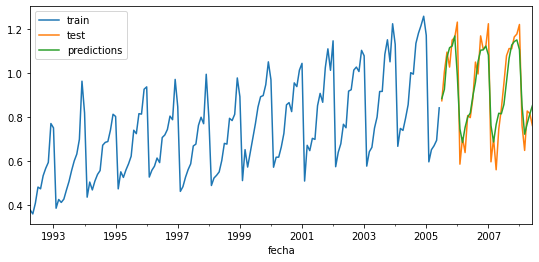

In [31]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )


forecaster.fit(y=data_train.y, exog=data_train[['exog_1', 'exog_2']])

# Predict
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps, exog=data_test[['exog_1', 'exog_2']])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train.y.plot(ax=ax, label='train')
data_test.y.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test.y,
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

In [32]:
# Grid search hiperparameters and lags
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                    regressor      = RandomForestRegressor(random_state=123),
                    fun_predictors = create_predictors,
                    window_size    = 20
                )

# Regressor hiperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10]}

# Lags used as predictors
lags_grid = [3, 10, [1,2,3,20]]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train[['exog_1', 'exog_2']],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        metric      = 'mean_squared_error',
                        method      = 'backtesting',
                        initial_train_size    = int(len(data_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                    )

# Results grid Search
# ==============================================================================
results_grid

root       WARNING `lags_grid` ignored if forecaster is an instance of `ForecasterAutoregCustom`.
root       INFO  Number of models compared: 4
loop lags_grid: 100%|█████████████████████████████| 1/1 [00:04<00:00,  4.46s/it]
root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: custom predictors 
params: {'max_depth': 10, 'n_estimators': 50}



,lags,params,metric,max_depth,n_estimators
2,custom predictors,"{'max_depth': 10, 'n_estimators': 50}",0.052553,10,50
0,custom predictors,"{'max_depth': 5, 'n_estimators': 50}",0.053476,5,50
3,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.057799,10,100
1,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.057959,5,100


## Información de sesión

In [24]:
from sinfo import sinfo
sinfo()

-----
ipykernel   5.4.3
matplotlib  3.3.2
numpy       1.19.2
pandas      1.2.3
sinfo       0.3.1
skforecast  0.1.6
sklearn     0.24.1
tqdm        4.59.0
-----
IPython             7.20.0
jupyter_client      6.1.11
jupyter_core        4.7.1
notebook            6.2.0
-----
Python 3.7.9 (default, Aug 31 2020, 12:42:55) [GCC 7.3.0]
Linux-5.4.0-1039-aws-x86_64-with-debian-buster-sid
2 logical CPU cores, x86_64
-----
Session information updated at 2021-03-17 17:52
